In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
batch_size = 20
valid_size = 0.2
num_workers=0
transform = transforms.Compose([
                            ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))  #mean and standard deviation, 3 arguments as rgb images              
]
)
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [4]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [5]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified


In [6]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx = indices[split:]
valid_idx = indices[:split]
print("length of data:",num_train)
print(train_idx)
print(valid_idx)

length of data: 50000
[41698, 48632, 25645, 15295, 15423, 35292, 23996, 21692, 38461, 34827, 18026, 46000, 1435, 28383, 20267, 11045, 49689, 42950, 17697, 38280, 17034, 16824, 41759, 44947, 39051, 27980, 25903, 4015, 4551, 26261, 30217, 47363, 33282, 32036, 30967, 42171, 39987, 2453, 20662, 36270, 10208, 6590, 33295, 35552, 49849, 23911, 47549, 28938, 46583, 24657, 33520, 13271, 4070, 37468, 3319, 20542, 12690, 10865, 46749, 17401, 33164, 31472, 41445, 7015, 20037, 44184, 21833, 3807, 3091, 37803, 33537, 2497, 9416, 25752, 3924, 1639, 2732, 2477, 36687, 48895, 40838, 21604, 30423, 33322, 20329, 39979, 6988, 42246, 10132, 30088, 19766, 37346, 29815, 33728, 29125, 37216, 11969, 14198, 33455, 44878, 11580, 82, 27894, 29705, 30079, 37942, 535, 36065, 15156, 7595, 38877, 24226, 11188, 7377, 38130, 19497, 10518, 24169, 25350, 44183, 19965, 4352, 28450, 33813, 7575, 20635, 2620, 25410, 47753, 17358, 10217, 47477, 27820, 43609, 21853, 44494, 26966, 2704, 19365, 49405, 41327, 30502, 2076, 12077

In [7]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
#samples elements randomly from the list, without replacement
print(train_sampler,"\n",valid_sampler)

In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

In [9]:
%matplotlib inline
def imshow(img):
  img = img/2+0.5
  plt.imshow(np.transpose(img,(1,2,0)))

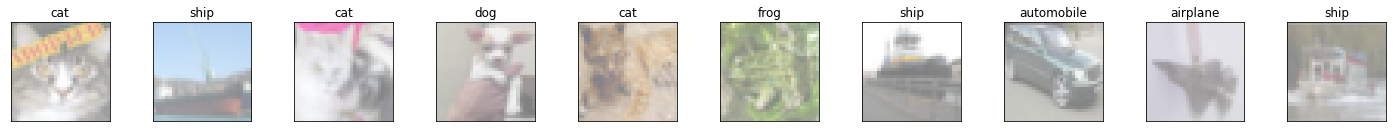

In [10]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

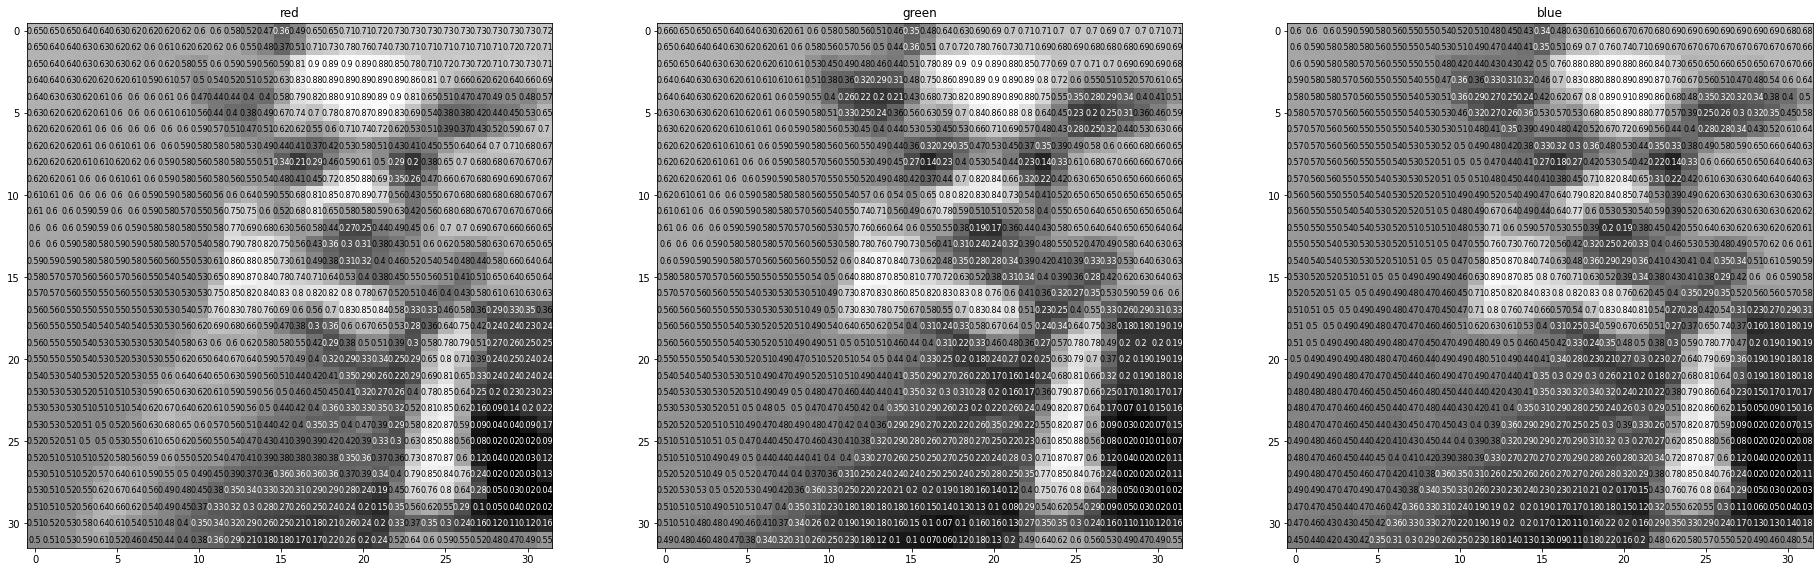

In [11]:
#single rgb image as 3 greyscale images
rgb_img = np.squeeze(images[3])
channels = ['red', 'green', 'blue']
fig = plt.figure(figsize=(32,32))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx+1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y]!=0 else 0
      ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', size=8, color='white' if img[x][y]<thresh else 'black')

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [13]:
model = NeuralNetwork()
model

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [14]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
n_epochs = 15
valid_loss_min = np.Inf 
eList = []
for e in range(n_epochs):
  eList.append(e+1)
tList=[]
vList=[]
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    #training model
    model.train()
    for data, target in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
    #validate model
    model.eval()
    for data, target in valid_loader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    tList.append(train_loss)
    vList.append(valid_loss)
    print('Epoch: {} \nTraining Loss: {:.6f} \nValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 
Training Loss: 1.776245 
Validation Loss: 0.401240
Epoch: 2 
Training Loss: 1.526213 
Validation Loss: 0.359841
Epoch: 3 
Training Loss: 1.340845 
Validation Loss: 0.316266
Epoch: 4 
Training Loss: 1.237417 
Validation Loss: 0.316497
Epoch: 5 
Training Loss: 1.169596 
Validation Loss: 0.280411
Epoch: 6 
Training Loss: 1.113587 
Validation Loss: 0.266523
Epoch: 7 
Training Loss: 1.062580 
Validation Loss: 0.254242
Epoch: 8 
Training Loss: 1.012572 
Validation Loss: 0.248309
Epoch: 9 
Training Loss: 0.966189 
Validation Loss: 0.239392
Epoch: 10 
Training Loss: 0.921629 
Validation Loss: 0.222072
Epoch: 11 
Training Loss: 0.883028 
Validation Loss: 0.214131
Epoch: 12 
Training Loss: 0.844667 
Validation Loss: 0.209434
Epoch: 13 
Training Loss: 0.811057 
Validation Loss: 0.196541
Epoch: 14 
Training Loss: 0.776678 
Validation Loss: 0.194740
Epoch: 15 
Training Loss: 0.749561 
Validation Loss: 0.185526


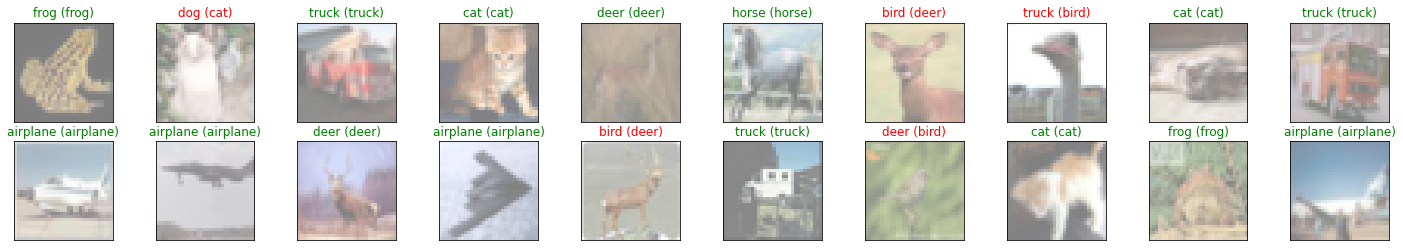

In [23]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images.numpy()
output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())
np.squeeze(preds_tensor.cpu().numpy())
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),color=("green" if preds[idx]==labels[idx].item() else "red"))

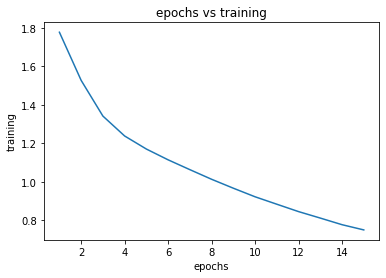

In [26]:
xPoints = np.array(eList)
yPoints = np.array(tList)
plt.xlabel("epochs")
plt.ylabel("training")
plt.title("epochs vs training")
plt.plot(xPoints,yPoints)
plt.show()

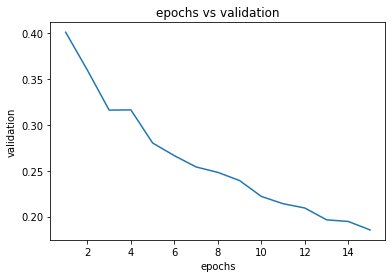

In [27]:
xPoints = np.array(eList)
yPoints = np.array(vList)
plt.xlabel("epochs")
plt.ylabel("validation")
plt.title("epochs vs validation")
plt.plot(xPoints,yPoints)
plt.show()

In [16]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in train_loader:
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)    
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) 
  np.squeeze(correct_tensor.cpu().numpy())
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
# average loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.118778

Test Accuracy of airplane: 80% (3239/4018)
Test Accuracy of automobile: 87% (3540/4026)
Test Accuracy of  bird: 57% (2332/4036)
Test Accuracy of   cat: 53% (2135/3985)
Test Accuracy of  deer: 70% (2783/3973)
Test Accuracy of   dog: 68% (2739/3981)
Test Accuracy of  frog: 78% (3133/3993)
Test Accuracy of horse: 80% (3237/4006)
Test Accuracy of  ship: 86% (3447/4007)
Test Accuracy of truck: 77% (3094/3975)

Test Accuracy (Overall): 74% (29679/40000)
